In [1]:
import sys
sys.path.append('..//')

import jax
import jax.numpy as jnp
from jax import jit
import time
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, ConditionalMomentsModel
from parsmooth.linearization import cubature, extended
from parsmooth.methods import iterated_smoothing


from population_model import make_parameters
from population_model import get_data as population_data


In [2]:
seed = 40
key =jax.random.PRNGKey(seed)

T = 1 + 2**7
lam = 10.
Q = jnp.array([[0.3**2]])
m0 = jnp.array([jnp.log(7.)])

true_states, observations = population_data(m0, T, Q, lam, key)



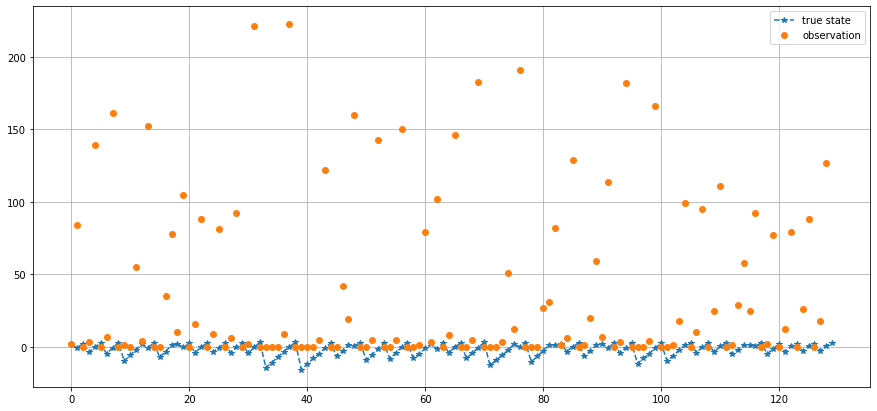

In [3]:
plt.figure(figsize=(15,7))
plt.plot(true_states, "*--", label = "true state")
plt.plot(observations, "o", label = "observation")
plt.legend()
plt.grid()
plt.show()



In [4]:
dim_x = 1
mean_f, cov_f, mean_h, cov_h, chol_f, chol_h = make_parameters(lam, Q)

In [5]:
transition_model = ConditionalMomentsModel(mean_f, cov_f)
observation_model = ConditionalMomentsModel(mean_h, cov_h)

m0 = np.random.randn(dim_x)
chol_x0 = np.random.randn(dim_x,dim_x)
cov_x0 = chol_x0 @ chol_x0.T
x0 = MVNStandard(m0, cov_x0)

m_nominal = np.random.randn(T + 1, dim_x)
P_nominal = jnp.repeat(np.eye(dim_x, dim_x)[None, ...], T + 1, axis=0)
x_nominal = MVNStandard(m_nominal, P_nominal)



# Iterated result - Extended

In [6]:
iteration = 100


In [7]:
extended_std_seq = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      extended, x_nominal, False,
                                      criterion=lambda i, *_: i < iteration)


In [8]:
extended_std_par = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      extended, x_nominal, True,
                                      criterion=lambda i, *_: i < iteration)


In [9]:
np.testing.assert_array_almost_equal(extended_std_seq.mean,
                                     extended_std_par.mean, decimal=9)


# Iterated result - Cubature

In [10]:
cubature_std_seq = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      cubature, x_nominal, False,
                                      criterion=lambda i, *_: i < iteration)


In [11]:
cubature_std_par = iterated_smoothing(observations, x0, transition_model, observation_model,
                                      cubature, x_nominal, True,
                                      criterion=lambda i, *_: i < iteration)


In [12]:
np.testing.assert_array_almost_equal(cubature_std_seq.mean,
                                     cubature_std_par.mean, decimal=9)

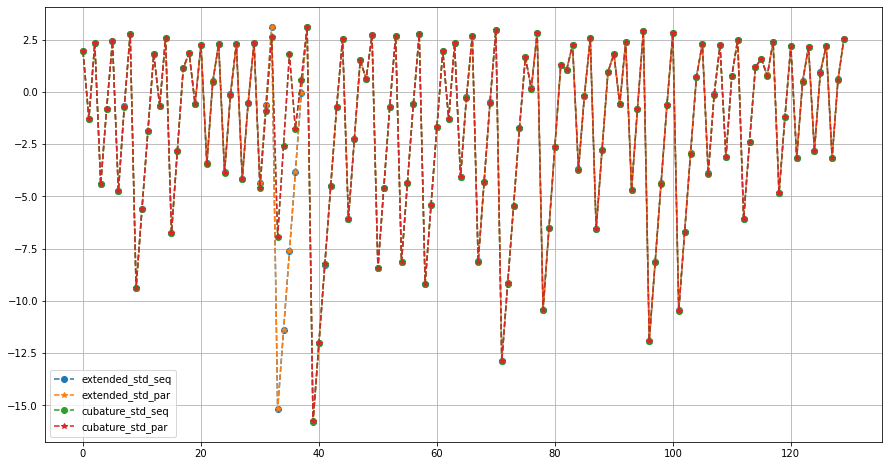

In [13]:
plt.figure(figsize=(15,8))

plt.plot(extended_std_seq.mean,"o--", label = "extended_std_seq")
plt.plot(extended_std_par.mean, "*--", label = "extended_std_par")
plt.plot(cubature_std_seq.mean,"o--", label = "cubature_std_seq")
plt.plot(cubature_std_par.mean, "*--", label = "cubature_std_par")

plt.grid()
plt.legend()
plt.show()


# Runtime comparison

In [14]:
def func(method, lengths, n_runs=100, n_iter=100):
    res_mean = []
    for k, j in enumerate(lengths):
        print(f"Iteration {k+1} out of {len(lengths)}", end="\r")
        observations_slice = observations[:j]
        
        init_linearizations_points_slice = x_nominal.mean[:j+1]
        init_linearizations_covs_slice = x_nominal.cov[:j+1]
        init_linearizations_states = MVNStandard(init_linearizations_points_slice, init_linearizations_covs_slice)
        args = observations_slice, init_linearizations_states, n_iter

        s = method(*args)                
        s.mean.block_until_ready()
        run_times = []
        for _ in range(n_runs):
            tic = time.time()
            s_states = method(*args)
            s_states.mean.block_until_ready()
            toc = time.time()
            run_times.append(toc - tic)
        res_mean.append(np.mean(run_times))
    print()
    return np.array(res_mean)



In [15]:
lengths_space = np.logspace(2, int(np.log2(T)), num=10, base=2, dtype=int)


In [16]:
def IEKS_std_seq(y, x_nominal_trajectory, iteration):    
    return iterated_smoothing(y, x0, transition_model, observation_model,
                              extended, x_nominal_trajectory, False,
                              criterion=lambda i, *_: i < iteration)
    
    
def IEKS_std_par(y, x_nominal_trajectory, iteration):
    return iterated_smoothing(y, x0, transition_model, observation_model,
                              extended, x_nominal_trajectory, True,
                              criterion=lambda i, *_: i < iteration)    


def IPLS_std_seq(y, x_nominal_trajectory, iteration):
    return iterated_smoothing(y, x0, transition_model, observation_model,
                              cubature, x_nominal_trajectory, False,
                              criterion=lambda i, *_: i < iteration)


def IPLS_std_par(y, x_nominal_trajectory, iteration):   
    return iterated_smoothing(y, x0, transition_model, observation_model,
                              cubature, x_nominal_trajectory, True,
                              criterion=lambda i, *_: i < iteration)


In [17]:
gpu_IEKS_std_seq = jit(IEKS_std_seq, backend="gpu")
gpu_IEKS_std_par = jit(IEKS_std_par, backend="gpu")
gpu_IPLS_std_seq = jit(IPLS_std_seq, backend="gpu")
gpu_IPLS_std_par = jit(IPLS_std_par, backend="gpu")


In [18]:
gpu_IEKS_std_seq_time = func(gpu_IEKS_std_seq, lengths_space)


Iteration 10 out of 10


In [19]:
gpu_IEKS_std_par_time = func(gpu_IEKS_std_par, lengths_space)


Iteration 10 out of 10


In [20]:
gpu_IPLS_std_seq_time = func(gpu_IPLS_std_seq, lengths_space)


Iteration 10 out of 10


In [21]:
gpu_IPLS_std_par_time = func(gpu_IPLS_std_par, lengths_space)


Iteration 10 out of 10


In [22]:
# jnp.savez("new_outputs/GPU-population-model-time",
#           gpu_IEKS_std_seq_time=gpu_IEKS_std_seq_time,
#           gpu_IEKS_std_par_time=gpu_IEKS_std_par_time,
#           gpu_IPLS_std_seq_time=gpu_IPLS_std_seq_time,
#           gpu_IPLS_std_par_time=gpu_IPLS_std_par_time)


# RTX 3080 Ti GPU

In [25]:
with np.load("new_outputs/GPU-population-model-time.npz") as loaded:
    rts_gpu_IEKS_std_seq_time=loaded["gpu_IEKS_std_seq_time"]
    rts_gpu_IEKS_std_par_time=loaded["gpu_IEKS_std_par_time"]
    rts_gpu_IPLS_std_seq_time=loaded["gpu_IPLS_std_seq_time"]
    rts_gpu_IPLS_std_par_time=loaded["gpu_IPLS_std_par_time"]

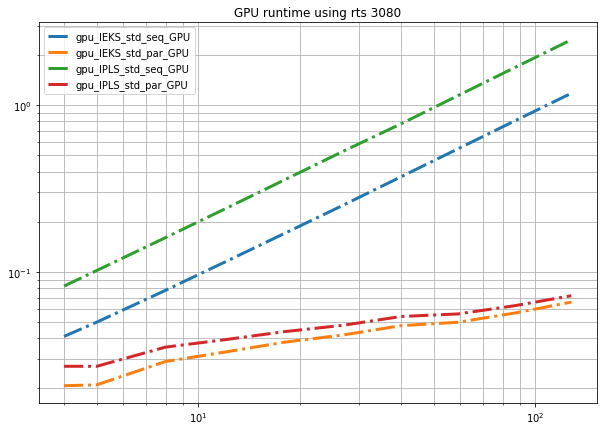

In [26]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, rts_gpu_IEKS_std_seq_time, label="gpu_IEKS_std_seq_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, rts_gpu_IEKS_std_par_time, label="gpu_IEKS_std_par_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, rts_gpu_IPLS_std_seq_time, label="gpu_IPLS_std_seq_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, rts_gpu_IPLS_std_par_time, label="gpu_IPLS_std_par_GPU", linestyle="-.", linewidth=3)
plt.grid(True, which="both")
plt.title("GPU runtime using rts 3080")
plt.legend()
plt.show()


In [27]:
import pandas as pd
rts_data = np.stack([lengths_space,
                 rts_gpu_IEKS_std_seq_time,
                 rts_gpu_IEKS_std_par_time,
                 rts_gpu_IPLS_std_seq_time,
                 rts_gpu_IPLS_std_par_time],
                 axis=1)

columns = ["time_steps",
          "gpu_IEKS_std_seq_time",
          "gpu_IEKS_std_par_time",
          "gpu_IPLS_std_seq_time",
          "gpu_IPLS_std_par_time"]

rts_df = pd.DataFrame(data=rts_data, columns=columns)
# rts_df.to_csv("new_outputs/GPU-population-model.csv")

# Tesla A100 data

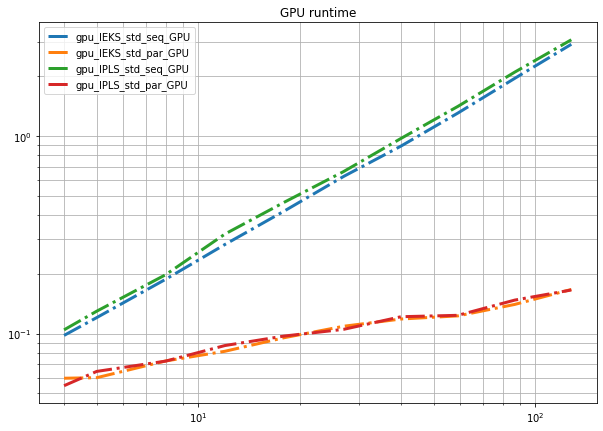

In [23]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, gpu_IEKS_std_seq_time, label="gpu_IEKS_std_seq_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_IEKS_std_par_time, label="gpu_IEKS_std_par_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_IPLS_std_seq_time, label="gpu_IPLS_std_seq_GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_IPLS_std_par_time, label="gpu_IPLS_std_par_GPU", linestyle="-.", linewidth=3)
plt.grid(True, which="both")
plt.title("GPU runtime")
plt.legend()
plt.show()



In [25]:
import pandas as pd
data = np.stack([lengths_space,
                 gpu_IEKS_std_seq_time,
                 gpu_IEKS_std_par_time,
                 gpu_IPLS_std_seq_time,
                 gpu_IPLS_std_par_time],
                 axis=1)

columns = ["time_steps",
          "gpu_IEKS_std_seq_time",
          "gpu_IEKS_std_par_time",
          "gpu_IPLS_std_seq_time",
          "gpu_IPLS_std_par_time"]

df = pd.DataFrame(data=data, columns=columns)
# df.to_csv("outputs/GPU-population-model.csv")

